# Распознавание звука

## Импорт библиотек

In [74]:
import sys 
import os 

import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.metrics import classification_report

import tensorflow as tf 
from tensorflow import keras
 
from IPython import display 

In [75]:
sys.path.append('D:/Programming/Python')

In [76]:
from tools import show_correlation, export2, rounding
from decorators import timeit
from ml_tools import training_plot, predictions_plot

# Импорт данных

In [77]:
os.listdir()

['automatic_speech_recognition.ipynb', 'commands']

In [100]:
training_set, validation_set = tf.keras.utils.audio_dataset_from_directory( 
    directory='commands', 
    batch_size=16, 
    validation_split=0.2, 
    output_sequence_length=16_000, 
    seed=0, 
    subset='both') 

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.


In [79]:
label_names = np.array(training_set.class_names) 
print("label names:", label_names)

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


## Обработка данных

Удаление стерео, квадро и др дополнительных осей данных аудиоканала.

In [107]:
def squeeze(audio, labels): 
  '''Decoding audio'''
  audio = tf.squeeze(audio, axis=-1) 
  return audio, labels 

In [108]:
training_set = training_set.map(squeeze, tf.data.AUTOTUNE) 
validation_set = validation_set.map(squeeze, tf.data.AUTOTUNE)

In [81]:
audio, label = next(iter(training_set)) 
display.display(display.Audio(audio[0], rate=16000))

## Визуализация

In [82]:
def plot_wave(waveform, label): 
    plt.figure(figsize=(10, 3)) 
    plt.title(label) 
    plt.plot(waveform) 
    plt.xlim([0, 16000]) 
    plt.ylim([-1, 1]) 
    plt.xlabel('Time') 
    plt.ylabel('Amplitude') 
    plt.grid(True) 
    plt.show()

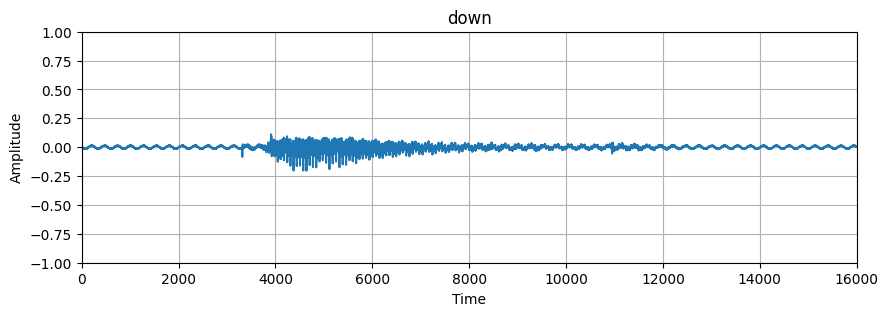

In [83]:
plot_wave(audio[0], label_names[label[0]]) 

In [84]:
def get_spectrogram(waveform): 
    '''Convert waveform to spectrogram '''
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128) 
    spectrogram = tf.abs(spectrogram) 
    return spectrogram[..., tf.newaxis] 

In [85]:
def plot_spectrogram(spectrogram, label): 
    spectrogram = np.squeeze(spectrogram, axis=-1) 
    log_spec = np.log(spectrogram.T + np.finfo(float).eps) 
    plt.figure(figsize=(10, 3)) 
    plt.title(label) 
    plt.imshow(log_spec, aspect='auto', origin='lower') 
    plt.colorbar(format='%+2.0f dB') 
    plt.xlabel('Time') 
    plt.ylabel('Frequency') 
    plt.show()

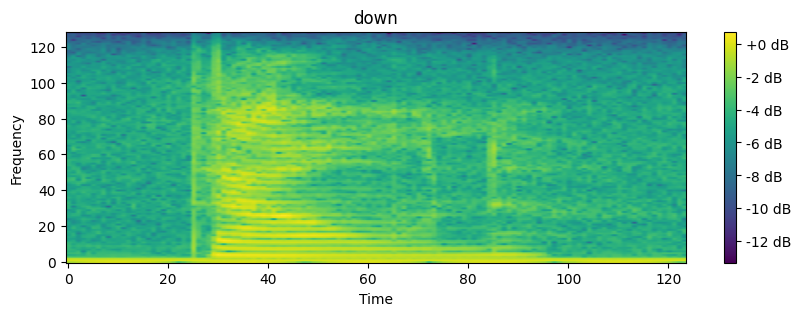

In [86]:
plot_spectrogram(get_spectrogram(audio[0]), label_names[label[0]])

## Преобразование аудио в изображение спектограммы

In [87]:
def get_spectrogram_dataset(dataset): 
    dataset = dataset.map(lambda x, y: (get_spectrogram(x), y), 
        num_parallel_calls=tf.data.AUTOTUNE) 
    return dataset

## Разделение данных

In [88]:
#train_text_split

train_set = get_spectrogram_dataset(training_set) 
validation_set = get_spectrogram_dataset(validation_set) 
  
val_set = validation_set.take(validation_set.cardinality() // 2) 
test_set = validation_set.skip(validation_set.cardinality() // 2)

Проврека размерности

In [89]:
train_set_shape = train_set.element_spec[0].shape 
val_set_shape = val_set.element_spec[0].shape 
test_set_shape = test_set.element_spec[0].shape 
  
print("Train set shape:", train_set_shape) 
print("Validation set shape:", val_set_shape) 
print("Testing set shape:", test_set_shape)

Train set shape: (None, 124, 129, 1)
Validation set shape: (None, 124, 129, 1)
Testing set shape: (None, 124, 129, 1)


## Построение модели

In [90]:
def get_model(input_shape, num_labels): 

    model = tf.keras.Sequential([ 
        tf.keras.layers.Input(shape=input_shape), 

        tf.keras.layers.Resizing(64, 64), 
        tf.keras.layers.Normalization(), 
          
        tf.keras.layers.Conv2D(64, 3, activation='relu'), 
        tf.keras.layers.Conv2D(128, 3, activation='relu'), 
        tf.keras.layers.MaxPooling2D(), 
        tf.keras.layers.Dropout(0.5), 
        tf.keras.layers.Flatten(), 
          
        tf.keras.layers.Dense(256, activation='relu'), 
        tf.keras.layers.Dropout(0.5), 
          
        tf.keras.layers.Dense(num_labels, activation='softmax') 
    ]) 
    model.summary() 
    return model 

In [91]:
input_shape = next(iter(train_set))[0][0].shape 
print("Input shape:", input_shape) 
num_labels = len(label_names) 
  
model = get_model(input_shape, num_labels)

Input shape: (124, 129, 1)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_2 (Resizing)       (None, 64, 64, 1)         0         
                                                                 
 normalization_2 (Normaliza  (None, 64, 64, 1)         3         
 tion)                                                           
                                                                 
 conv2d_4 (Conv2D)           (None, 62, 62, 64)        640       
                                                                 


 conv2d_5 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 128)       0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 30, 30, 128)       0         
                                                                 
 flatten_2 (Flatten)         (None, 115200)            0         
                                                                 
 dense_4 (Dense)             (None, 256)               29491456  
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 8)                 2056      
                                                                 
Total para

In [92]:
model.compile( 
    optimizer=tf.keras.optimizers.Adam(), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    metrics=[tf.keras.metrics.Accuracy(), 
             tf.keras.metrics.Recall(),
             tf.keras.metrics.Precision()], 
) 

## Обучение модели

In [93]:
epochs = 10
verbose = True

monitor = 'loss'
min_delta = 0.01
patience = 5

callbacks = [keras.callbacks.EarlyStopping(monitor=monitor, min_delta=min_delta, patience=patience, verbose=verbose),
             keras.callbacks.ModelCheckpoint(monitor=monitor, filepath='checkpoints/model_{epoch:d}.keras', save_best_only=True, verbose=verbose)]

In [94]:
history = model.fit( 
    train_set, 
    validation_data=val_set, 
    epochs=epochs, 
)

Epoch 1/10


400/400 [==============================] - 91s 225ms/step - loss: 1.4677 - accuracy: 0.4997 - val_loss: 0.8289 - val_accuracy: 0.7725
Epoch 2/10
400/400 [==============================] - 86s 216ms/step - loss: 0.7838 - accuracy: 0.7398 - val_loss: 0.6592 - val_accuracy: 0.8012
Epoch 3/10
400/400 [==============================] - 85s 213ms/step - loss: 0.5473 - accuracy: 0.8200 - val_loss: 0.4842 - val_accuracy: 0.8388
Epoch 4/10
400/400 [==============================] - 89s 222ms/step - loss: 0.4237 - accuracy: 0.8578 - val_loss: 0.4480 - val_accuracy: 0.8700
Epoch 5/10
400/400 [==============================] - 89s 223ms/step - loss: 0.3573 - accuracy: 0.8777 - val_loss: 0.4389 - val_accuracy: 0.8687
Epoch 6/10
400/400 [==============================] - 91s 227ms/step - loss: 0.3170 - accuracy: 0.8988 - val_loss: 0.3859 - val_accuracy: 0.8750
Epoch 7/10
400/400 [==============================] - 93s 232ms/step - loss: 0.2633 - accuracy: 0.9141 - val_loss: 0.3644 - val_accuracy: 0.8

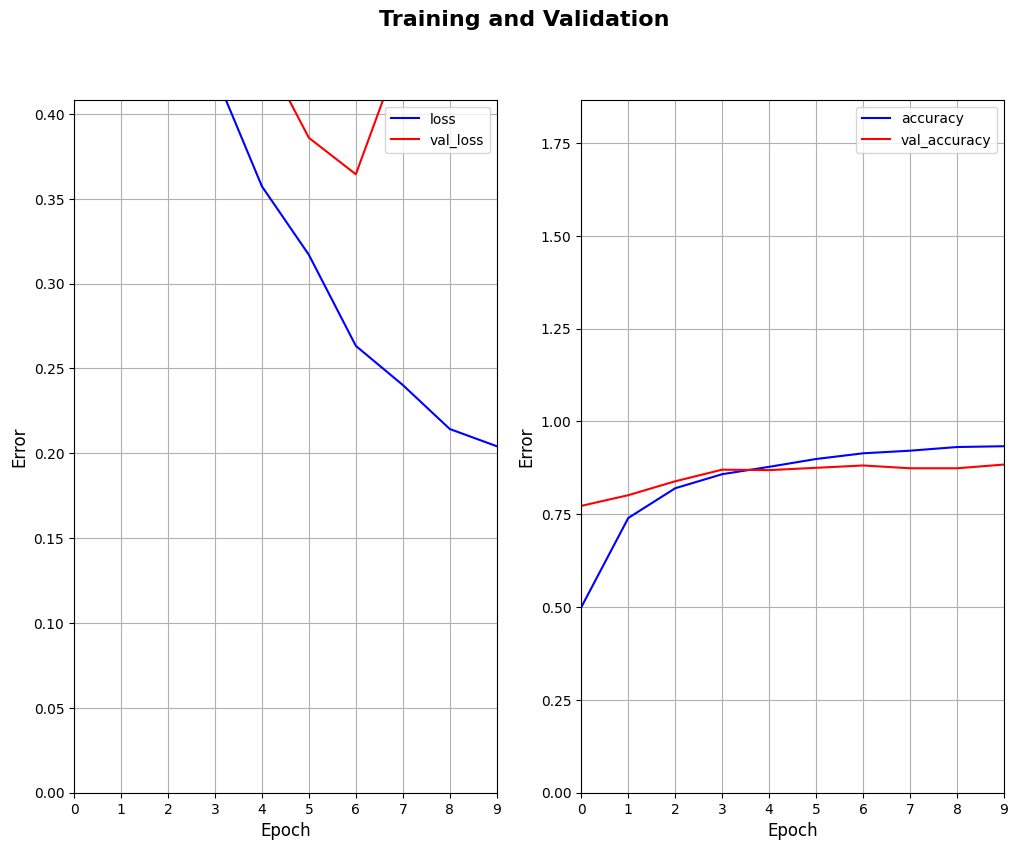

In [95]:
training_plot(history)

## Оценка модели

Матрица путаницы

50/50 [==============================] - 2s 38ms/step


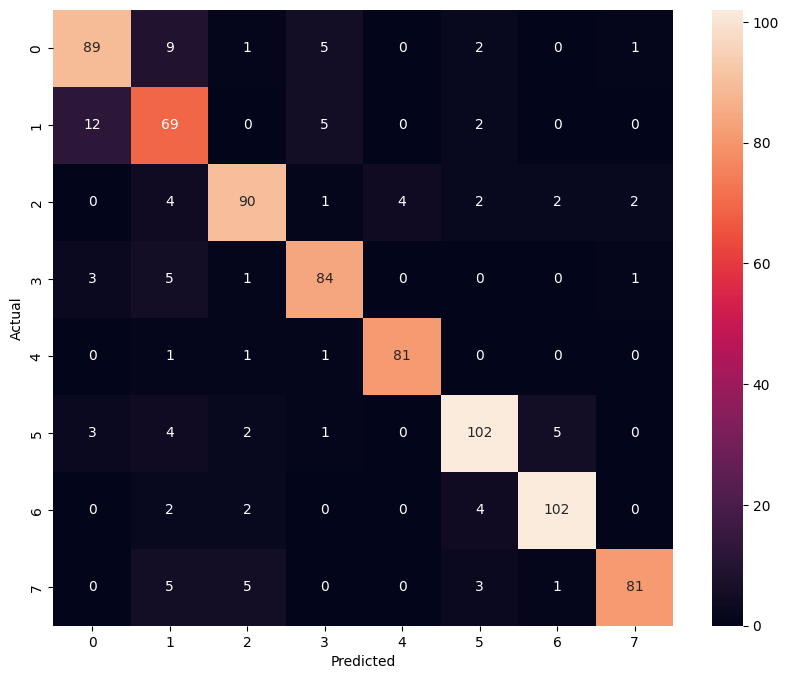

In [96]:
y_pred = np.argmax(model.predict(test_set), axis=1) 
y_true = np.concatenate([y for x, y in test_set], axis=0) 
cm = tf.math.confusion_matrix(y_true, y_pred) 
  
# Plotting the confusion matrix 
plt.figure(figsize=(10, 8)) 
sns.heatmap(cm, annot=True, fmt='g') 
plt.xlabel('Predicted') 
plt.ylabel('Actual') 
plt.show()

Классификационный отчет

In [97]:
report = classification_report(y_true, y_pred) 
print(report)

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       107
           1       0.70      0.78      0.74        88
           2       0.88      0.86      0.87       105
           3       0.87      0.89      0.88        94
           4       0.95      0.96      0.96        84
           5       0.89      0.87      0.88       117
           6       0.93      0.93      0.93       110
           7       0.95      0.85      0.90        95

    accuracy                           0.87       800
   macro avg       0.87      0.87      0.87       800
weighted avg       0.88      0.87      0.87       800



## Тестирование

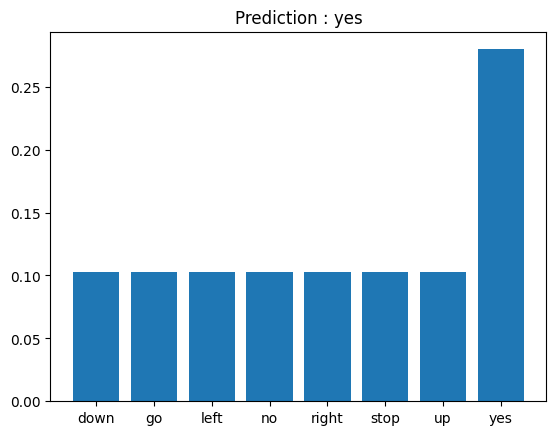

In [98]:
path = 'commands/yes/004ae714_nohash_0.wav'
Input = tf.io.read_file(str(path)) 
x, sample_rate = tf.audio.decode_wav(Input, desired_channels=1, desired_samples=16000,) 
audio, labels = squeeze(x, 'yes') 
  
waveform = audio 
display.display(display.Audio(waveform, rate=16000)) 
  
x = get_spectrogram(audio) 
x = tf.expand_dims(x, axis=0) 
  
prediction = model(x) 
plt.bar(label_names, tf.nn.softmax(prediction[0])) 
plt.title('Prediction : '+label_names[np.argmax(prediction, axis=1).item()]) 
plt.show()